In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# Load the data
df = pd.read_csv('/content/drive/MyDrive/cleaned_credit_data.csv')

Mounted at /content/drive


In [2]:
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data Types:\n{df.dtypes}")
df.head()

Dataset Shape: (101140, 39)
Columns: ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'fico_range_low', 'fico_range_high', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'default', 'emp_length_years', 'term_months']
Data Types:
loan_amnt                     float64
funded_amnt                   float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
sub_grade                      object
emp_title                      object
emp_length            

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default,emp_length_years,term_months
0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,...,564.0,560.0,0.0,0.0,722.0,144904.0,9300.0,0,10.0,36
1,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,...,699.0,695.0,0.0,0.0,0.0,204396.0,111800.0,0,10.0,36
2,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,...,704.0,700.0,0.0,0.0,0.0,189699.0,14000.0,0,10.0,60
3,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,...,704.0,700.0,0.0,0.0,0.0,331730.0,34000.0,0,3.0,60
4,11950.0,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,...,759.0,755.0,0.0,0.0,0.0,12798.0,12900.0,0,4.0,36


In [3]:
# Check for null values
print("Null Values:")
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Basic info about the dataset
print(f"\nData Types:")
print(df.dtypes.value_counts())

# Target variable analysis
print(f"\nTarget Variable Distribution:")
print(df['loan_status'].value_counts())
print(f"\nTarget Variable Percentages:")
print(df['loan_status'].value_counts(normalize=True) * 100)

Null Values:
emp_title     6502
emp_length    6477
revol_util      41
dtype: int64

Duplicate rows: 0

Data Types:
float64    25
object     12
int64       2
Name: count, dtype: int64

Target Variable Distribution:
loan_status
Fully Paid     80956
Charged Off    20183
Default            1
Name: count, dtype: int64

Target Variable Percentages:
loan_status
Fully Paid     80.043504
Charged Off    19.955507
Default         0.000989
Name: proportion, dtype: float64


In [4]:
# Remove duplicates if any
df = df.drop_duplicates()

# Handle missing values - fill numerical with median, categorical with mode
numerical_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

print(f"Dataset shape after cleaning: {df.shape}")
print(f"Remaining null values: {df.isnull().sum().sum()}")

Dataset shape after cleaning: (101140, 39)
Remaining null values: 0


In [5]:
def prepare_features(df):
    df_processed = df.copy()

    # Separate target variable and drop the 'default' column which is the same as the target
    if 'loan_status' in df_processed.columns:
        y = df_processed['loan_status']
        X = df_processed.drop(['loan_status', 'default'], axis=1)
    else:
        raise ValueError("Target variable 'loan_status' not found")

    # Combine 'Default' and 'Charged Off' classes
    y = y.replace('Default', 'Charged Off')

    # Encode target variable
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)

    # Handle categorical variables
    categorical_columns = X.select_dtypes(include=['object']).columns

    # Label encoding for categorical variables
    label_encoders = {}
    for col in categorical_columns:
        if col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le

    # Feature scaling for numerical variables
    numerical_columns = X.select_dtypes(include=[np.number]).columns
    scaler = RobustScaler()  # Using RobustScaler as it's less sensitive to outliers
    X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

    return X, y_encoded, label_encoders, le_target, scaler

# Assuming df_clean is the cleaned dataframe from previous steps
X, y, label_encoders, target_encoder, feature_scaler = prepare_features(df)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target classes: {target_encoder.classes_}")
print(f"Target distribution: {np.bincount(y)}")

Features shape: (101140, 37)
Target shape: (101140,)
Target classes: ['Charged Off' 'Fully Paid']
Target distribution: [20184 80956]


In [6]:
# Create a copy for preprocessing
df_processed = df.copy()

# Encode categorical variables
label_encoders = {}
categorical_columns = df_processed.select_dtypes(include=['object']).columns

for col in categorical_columns:
    if col != 'loan_status':  # Don't encode target variable yet
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le

# Encode target variable
target_encoder = LabelEncoder()
df_processed['loan_status_encoded'] = target_encoder.fit_transform(df_processed['loan_status'])

print("Encoding completed!")
print(f"Target mapping: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

Encoding completed!
Target mapping: {'Charged Off': np.int64(0), 'Default': np.int64(1), 'Fully Paid': np.int64(2)}


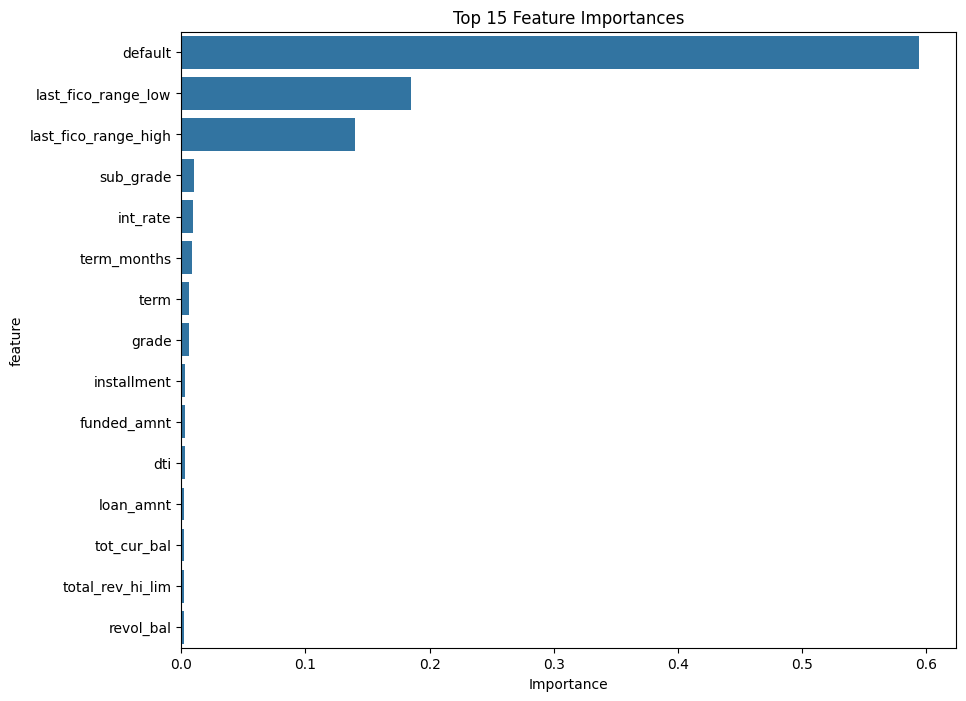

Top 10 Most Important Features:
                 feature  importance
35               default    0.594239
29   last_fico_range_low    0.184858
28  last_fico_range_high    0.140004
6              sub_grade    0.010179
3               int_rate    0.009808
37           term_months    0.008540
2                   term    0.006221
5                  grade    0.006085
4            installment    0.003081
1            funded_amnt    0.002950


In [7]:
# Prepare features and target
X = df_processed.drop(['loan_status', 'loan_status_encoded'], axis=1)
y = df_processed['loan_status_encoded']

# Quick feature importance using RandomForest
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X, y)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 important features
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

In [8]:
# Remove 'default' from feature_importance as it's the target variable
if 'default' in feature_importance['feature'].tolist():
    feature_importance = feature_importance[feature_importance['feature'] != 'default']

# Select top features (you can adjust this number)
top_features = feature_importance.head(20)['feature'].tolist()
X_selected = X[top_features]

# Recombine 'Default' and 'Charged Off' classes for splitting
# Assuming 'loan_status_encoded' has 'Default' as 1 and 'Charged Off' as 0 based on previous output
# If the mapping is different, adjust the condition below.
y_combined = df_processed['loan_status'].replace('Default', 'Charged Off')

# Re-encode the target variable after combining classes
target_encoder_combined = LabelEncoder()
y_encoded_combined = target_encoder_combined.fit_transform(y_combined)


# Split the data using the combined target variable
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_encoded_combined, test_size=0.2, random_state=42, stratify=y_encoded_combined
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Target classes after combining: {target_encoder_combined.classes_}")
print(f"Target distribution after combining: {np.bincount(y_encoded_combined)}")

Training set shape: (80912, 20)
Test set shape: (20228, 20)
Target classes after combining: ['Charged Off' 'Fully Paid']
Target distribution after combining: [20184 80956]


In [9]:
from sklearn.impute import SimpleImputer

# Dictionary to store models and results
models = {}
results = {}

# Impute missing values after splitting but before scaling
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


# Scale the features after imputation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# 1. Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_prob = lr.predict_proba(X_test_scaled)[:, 1]

models['Logistic Regression'] = lr
results['Logistic Regression'] = {
    'accuracy': lr.score(X_test_scaled, y_test),
    'auc_score': roc_auc_score(y_test, lr_prob)
}

# 2. Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_imputed, y_train)  # Use imputed data for RF as it handles NaNs or train on scaled data as well
rf_pred = rf.predict(X_test_imputed)
rf_prob = rf.predict_proba(X_test_imputed)[:, 1]

models['Random Forest'] = rf
results['Random Forest'] = {
    'accuracy': rf.score(X_test_imputed, y_test),
    'auc_score': roc_auc_score(y_test, rf_prob)
}

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

Training Logistic Regression...
Training Random Forest...

Model Performance Comparison:
                     accuracy  auc_score
Logistic Regression  0.915068   0.955093
Random Forest        0.915167   0.951440


In [10]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# XGBoost Model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))
print(f"XGBoost ROC AUC Score: {roc_auc_score(y_test, xgb_prob):.4f}")

# Feature importance
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Important Features (XGBoost):")
print(xgb_importance.head(10))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      4037
           1       0.95      0.95      0.95     16191

    accuracy                           0.92     20228
   macro avg       0.87      0.87      0.87     20228
weighted avg       0.92      0.92      0.92     20228

XGBoost ROC AUC Score: 0.9570

Top 10 Important Features (XGBoost):
                 feature  importance
1   last_fico_range_high    0.455154
0    last_fico_range_low    0.313638
4            term_months    0.082666
5                   term    0.044182
8            funded_amnt    0.008843
10             loan_amnt    0.008839
7            installment    0.008515
16             total_acc    0.007071
9                    dti    0.006886
19        fico_range_low    0.006402


In [11]:
from sklearn.ensemble import VotingClassifier

# Create ensemble of best models
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ],
    voting='soft'  # Use probability averaging
)

# Train ensemble
ensemble_model.fit(X_train, y_train)

# Predictions
ensemble_pred = ensemble_model.predict(X_test)
ensemble_prob = ensemble_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Ensemble Classification Report:")
print(classification_report(y_test, ensemble_pred))
print(f"Ensemble ROC AUC Score: {roc_auc_score(y_test, ensemble_prob):.4f}")

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4037
           1       0.95      0.95      0.95     16191

    accuracy                           0.92     20228
   macro avg       0.87      0.87      0.87     20228
weighted avg       0.92      0.92      0.92     20228

Ensemble ROC AUC Score: 0.9552


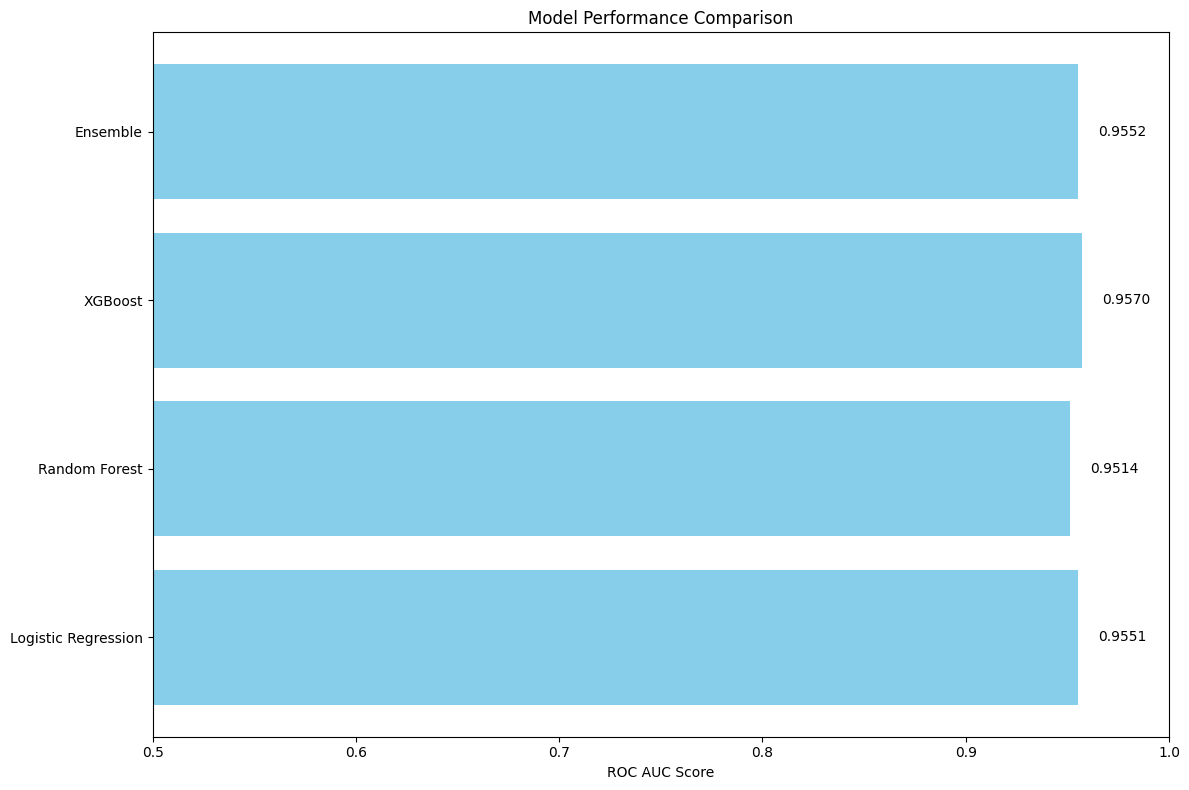


Model Performance Ranking (by ROC AUC Score):
1. XGBoost: 0.9570
2. Ensemble: 0.9552
3. Logistic Regression: 0.9551
4. Random Forest: 0.9514


In [12]:
import matplotlib.pyplot as plt

# Compare all models
models_performance = {
    'Logistic Regression': roc_auc_score(y_test, lr_prob),  # From your existing code
    'Random Forest': roc_auc_score(y_test, rf_prob),       # From your existing code
    'XGBoost': roc_auc_score(y_test, xgb_prob),
    'Ensemble': roc_auc_score(y_test, ensemble_prob)
}

# Plot comparison
plt.figure(figsize=(12, 8))
models = list(models_performance.keys())
scores = list(models_performance.values())

plt.barh(models, scores, color='skyblue')
plt.xlabel('ROC AUC Score')
plt.title('Model Performance Comparison')
plt.xlim(0.5, 1.0)

# Add score labels on bars
for i, score in enumerate(scores):
    plt.text(score + 0.01, i, f'{score:.4f}', va='center')

plt.tight_layout()
plt.show()

# Print sorted results
print("\nModel Performance Ranking (by ROC AUC Score):")
sorted_performance = sorted(models_performance.items(), key=lambda x: x[1], reverse=True)
for i, (model, score) in enumerate(sorted_performance, 1):
    print(f"{i}. {model}: {score:.4f}")

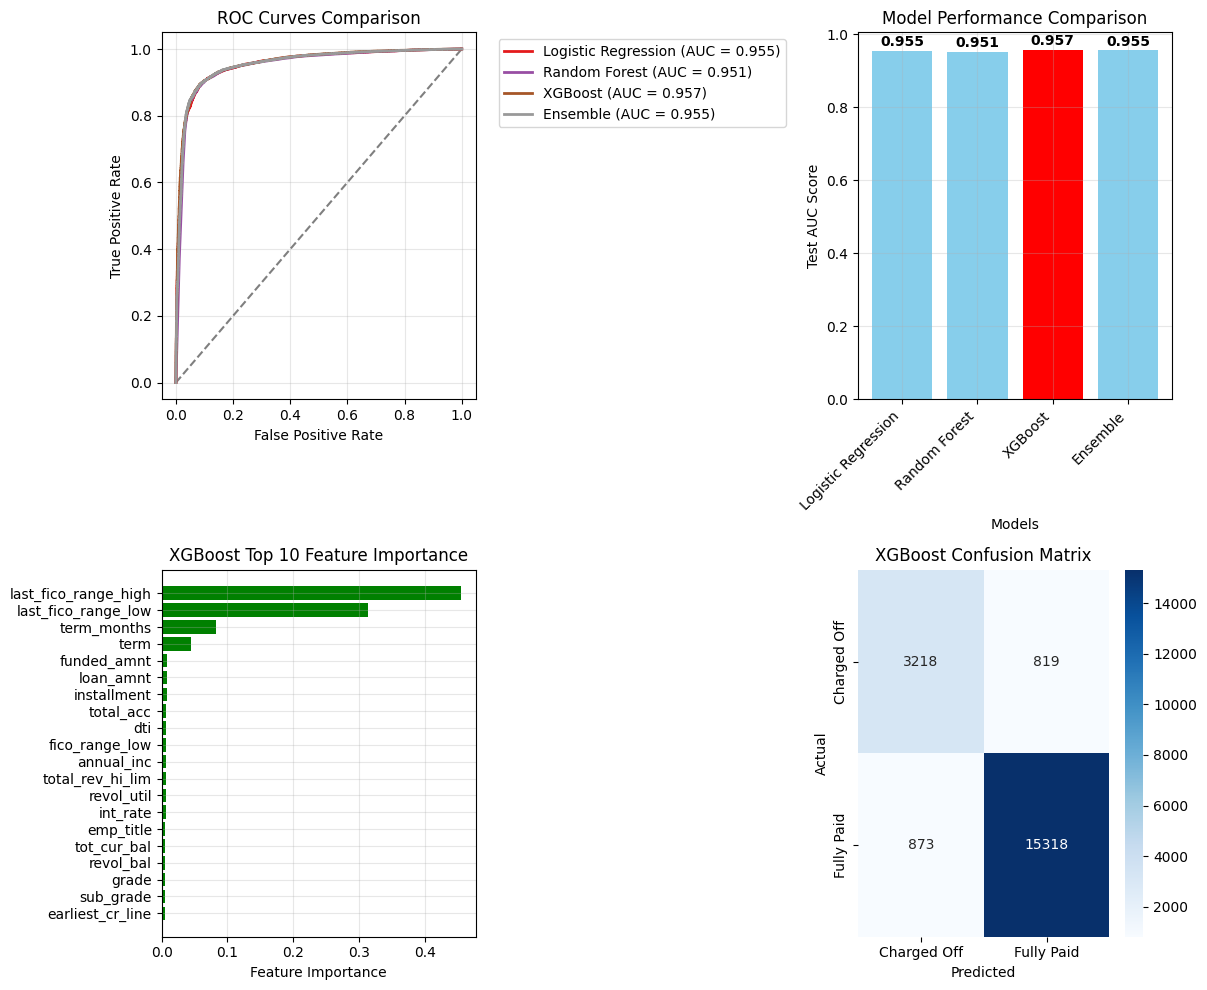


Detailed XGBoost Classification Report:
              precision    recall  f1-score   support

 Charged Off       0.79      0.80      0.79      4037
  Fully Paid       0.95      0.95      0.95     16191

    accuracy                           0.92     20228
   macro avg       0.87      0.87      0.87     20228
weighted avg       0.92      0.92      0.92     20228



In [13]:
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score

# Create a dictionary of trained models
model_objects = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'XGBoost': xgb_model,
    'Ensemble': ensemble_model
}

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. ROC Curves Comparison
axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
colors = plt.cm.Set1(np.linspace(0, 1, len(model_objects)))

for (name, model), color in zip(model_objects.items(), colors):
    # Determine which test set to use based on the model type
    if name == 'Logistic Regression':
        X_test_use = X_test_scaled
    else:
        X_test_use = X_test

    y_proba = model.predict_proba(X_test_use)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    axes[0, 0].plot(fpr, tpr, color=color, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curves Comparison')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# 2. Model Performance Bar Chart (Using the results dictionary from previous cell)
model_names = list(models_performance.keys())
test_aucs = [models_performance[name] for name in model_names]

bars = axes[0, 1].bar(range(len(model_names)), test_aucs,
                     color=['red' if name == 'XGBoost' else 'skyblue' for name in model_names])
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Test AUC Score')
axes[0, 1].set_title('Model Performance Comparison')
axes[0, 1].set_xticks(range(len(model_names)))
axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, auc in zip(bars, test_aucs):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                   f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. XGBoost Feature Importance (Using xgb_importance from previous cell)
axes[1, 0].barh(range(len(xgb_importance)), xgb_importance['importance'], color='green')
axes[1, 0].set_yticks(range(len(xgb_importance)))
axes[1, 0].set_yticklabels(xgb_importance['feature'])
axes[1, 0].set_xlabel('Feature Importance')
axes[1, 0].set_title('XGBoost Top 10 Feature Importance')
axes[1, 0].invert_yaxis() # Invert y-axis to have the most important feature at the top
axes[1, 0].grid(True, alpha=0.3)


# 4. Confusion Matrix for XGBoost
cm = confusion_matrix(y_test, xgb_pred) # Use xgb_pred from previous cell
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('XGBoost Confusion Matrix')
axes[1, 1].set_xticklabels(target_encoder_combined.classes_) # Use target_encoder_combined from previous cell
axes[1, 1].set_yticklabels(target_encoder_combined.classes_)

plt.tight_layout()
plt.show()

# Print detailed classification report for XGBoost
print("\nDetailed XGBoost Classification Report:")
print("=" * 50)
print(classification_report(y_test, xgb_pred, target_names=target_encoder_combined.classes_))